# "Training a UNet for Accurate Facial Attribute Profiling (Part 1 of 2)"
> "Accurate facial attribute estimation using digital images is important because facial attributes are among the individual features that are most commonly cited as cause for bias (and discrimination).  This article describes an approach to facial attribute profiling, which is a novel application to the best knowledge of the authors.  The approach uses the ubiquitous supervised learning UNet architecture first published in the Biotech community, with a ResNet34 backbone.  The UNet in this exercise was trained on the Mut1ny Face dataset to produce an accurate segmentation map of the human face."

- toc: true
- branch: master
- badges: true
- author: Aaron Soellinger & Eric Schniter
- comments: true
- categories: [research, perception, image]
- image: --
- hide: false
- search_exclude: false

# Objective
To train an accurate segmentation model to label face images in terms of facial landmarks or regions.  This output will be used to enable enhanced facial profile features such as skin tones, facial width to height ratios and other features used in scientific literature to describe faces.  The notion of acceptable accuracy for a final model may depend a little bit upon the specific facial profile feature that we're attempting to estimate, but generally, a >90% accurate segmentation model will be the objective.

# Dataset
There were two main datasets used for this application.  The first was the Mut1ny Facial Headsegmentation dataset{% fn 1 %} which is comprised of images that contain faces, which have been labeled according to the regions of the face.  The second was a dataset kindly provided by Eric and Tim, which is comprised of faces, and are labeled according to the average L,A,B (CIE 1931) color values of an approximately 50 px x 50 px region of the left and right cheek, which is the best-practice for collecting skin color measurement from face images in the social sciences.  Additionally, there is an array of demographic and psychographic metadata attached to each individual who is photographed.  The second dataset is titled: Participant Faces from a Repeated Prisoner's Dilemma{% fn 2 %}.  This dataset is relied upon to validate the effectiveness of the end application, which is heavily discussed in part 2 of this blog.

# Benchmarks
There is a general discussion of benchmarks, but no specific benchmark metrics stated in the Mut1ny article{% fn 3 %},{% fn 4 %}

# Findings 
 - Non-trivial ETL was required to use Mut1ny Facial/Head Segmentation with the FastAIv2 Datablock API.  See the section called "Unexpected ETL Steps"
 - Transfer learning FTW.  FastAIv2 `unet_learner` with `resnet34` pre-trained weights delivers impressive performance with limited training.
 
# Infrastructure
Description of hardware and software stack used. 
  
## Hardware
 - CPU: Xeon 8 core  
 - Mem: 64 GB ECC  
 - GPU: Nvidia Quadro M4000  

## Software
 - Nvidia Driver Version: 440.100
 - CUDA Version: 10.2
 - Custom Docker Env (private)
  - Ubuntu 18
  - Python 3.6
  - FastAIv2 Stack  



# Code

In [1]:
#collapse-show
%matplotlib inline

from pathlib import Path
import random
import traceback

from bs4 import BeautifulSoup
import numpy as np

from fastai.basics import *
from fastai.vision import models
from fastai.vision.all import *
from fastai.metrics import *
from fastai.data.all import *
from fastai.callback import *

import wandb
from fastai.callback.wandb import *
import ray

/home/fortville/.local/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
#collapse-show
def get_tags_in_order(xml_file, tags_to_track):
    tags = {}
    with open(xml_file) as f:
        for line in f:
            for tag in tags_to_track:
                if tag in line:
                    if tag not in tags:
                        tags[tag] = []
                    tags[tag].append(line)
    return tags

def get_attribute(elem, tag, attrib):
    s = BeautifulSoup(elem, 'xml')
    return Path(s.find(tag)[attrib].replace('\\', '/'))


def get_y_fn(fp):
    l_str = str(img_to_l[fp])
    out = l_str \
        .replace('labels', 'labels_int') \
        .replace('png', 'tif')
    return out

## Unexpected ETL Steps
I was excited to utilize the new FastAIv2 library for this project because it was talked up a lot in the developer news.  Jeremy Howard claimed it was a complete re-write of FastAI from the ground up.{% fn 5 %}  The issue was that the Mut1ny Facial dataset was not structured in the same way as the example dataset used in the FastAI tutorials.  Those tutorial specify how to load the data, and how to train the models.  It turned out that the most difficult part of getting performance out of the segmentation model (in FastAI called `unet_learner`) was to correctly configure my dataset in the Datablock API.  Below is the description of the ETL effort required to load Mut1ny into FastAI.

The Mut1ny Facial dataset is comprised of images and their labels which in the case of segmentation, are called "segmentation masks" (or just masks).  The first issue is that the Mut1ny masks are not encoded like the masks that are presented in most tutorials, or I am not good enough at reading the FastAI documentation to figure out how to use the `PILMask` API to use the Mut1ny masks.  There were 2 key differences I noted:
- Mut1ny masks are labeled with 3 values (R,G,B) for each pixel, but FastAI requires a single integer.  Apparently, representing the color as a single integer e.g. [0,1,2, ..] is valid.
- The data as it is downloaded from Mut1ny has a different directory structure than is expected in the FastAI tutorial.  The correspondence between base image files and masks was found in an XML formatted file called `training.xml`.

I converted my files specified in the `mutiny_labels` object found below, to integers representing each class. The confusion arose from part I got thrown off by was that the label file is saved as a TIF (or other image file). My base image files were shape=(3,x,y), so I thought that I needed to make my mask that same shape, which did not make sense because there were no longer any R,G,B values, just the labels. However, that was not the case. You just need to get a matrix (x,y) and that can also be saved as an image, which can be loaded by the `PILMask` just as was in the Jeremy Segmentation tutorials from 2019 {% fn 6 %}.
![](images/segmentation_tutorial_screencapture.jpg)

Unfortunately, the other tutorials, such as *WaterKnight1998*{% fn 7 %} did not show the ETL step or code, and only briefly hinted in the section marked “Manual”. His problem is not multi-class like the facial masking, it is the binary hypothesis "tumor or not tumor".

## Parallelized ETL Implementation using Ray{% fn 8 %} framework

In [3]:
#collapse-show
# path = Path("/ws/data/skin-tone/headsegmentation_dataset_ccncsa")
path = Path("/data1/data/skin-tone/headsegmentation_dataset_ccncsa")
xml_file = path/'training.xml'

test_name = "test"

tags_to_track = ['srcimg', 'labelimg']

tags = get_tags_in_order(xml_file=xml_file, tags_to_track=tags_to_track)

srcimg_name = [
    get_attribute(elem=srcimg, tag='srcimg', attrib='name') 
    for srcimg in tags['srcimg']
]
labelimg_name = [
    get_attribute(elem=labelimg, tag='labelimg', attrib='name') 
    for labelimg in tags['labelimg']
]

pairs = []
for i, srcimg in enumerate(srcimg_name):
    pairs.append({
        'srcimg': srcimg,
        'labelimg': labelimg_name[i]
    })

fnames = [path/pair['srcimg'] for pair in pairs]
lnames = [path/pair['labelimg'] for pair in pairs]
img_to_l = {fname: lnames[i] for i, fname in enumerate(fnames)}

header = ('R','G','B','L')
mutiny_labels = [
    (0,0,0,'Background/undefined'),
    (255,0,0,'Lips'),
    (0,255,0,'Eyes'),
    (0,0,255,'Nose'),
    (255,255,0,'Hair'),
    (0,255,255,'Ears'),
    (255,0,255,'Eyebrows'),
    (255,255,255,'Teeth'),
    (128,128,128,'General face'),
    (255,192,192,'Facial hair'),
    (0,128,128,'Specs/sunglasses'),
    (255, 128, 128, '')
]

mutiny_labels = pd.DataFrame(mutiny_labels, columns=header)
mutiny_labels['I'] = mutiny_labels.index
label_map = {
    (rec['R'], rec['G'], rec['B']): rec['I'] 
    for rec in mutiny_labels.to_dict('records')
}
int_to_label = {
    rec['I']: rec['L']
    for rec in mutiny_labels.to_dict('records')
}
codes = mutiny_labels.L.values
# codes = np.append(codes, ['Error'])

name2id = {v:k for k,v in enumerate(codes)}

In [4]:
#collapse-show

@ray.remote(num_returns=1)
def label_color_to_int(fn, label_map):
    """
    For RGB labels.
    """
    img = PILImage.create(fn)
    dat = TensorImage(image2tensor(img))
    frame_labels = np.zeros(
        (int(dat.shape[1]), int(dat.shape[2])),
        dtype=int
    )
    for i in range(dat.shape[1]):
        for j in range(dat.shape[2]):
            R = int(dat[0, i, j])
            G = int(dat[1, i, j])
            B = int(dat[2, i, j])
            if (R,G,B) not in label_map:
                # undefined pixel identified
                print('PixelMapError', fn, (R,G,B))
                frame_labels[i,j] = len(label_map)
                continue
            label = label_map[(R,G,B)]
            frame_labels[i,j] = label
    return frame_labels

# ray.init(address='auto', _redis_password='****')
# int_label_dir = data_root/'labels_int'
# futures = []
# names = []
# print('Queuing up Jobs...')
# for lname in lnames:
#     ext = '/'.join(lname.parts[-2:])
#     outfp = int_label_dir/ext.replace('png', 'tif')
#     # if outfp.exists(): continue
#     names.append(outfp)
#     futures.append(
#         label_color_to_int.remote(
#             fn=lname, label_map=label_map
#         )
#     )
# print('Starting...')   
# for i, future in enumerate(futures):
#     try:
#         label_mat = ray.get(future)
#     except FileNotFoundError: 
#         traceback.print_exc()
#         continue
#     outfp = names[i]
#     outfp.parent.mkdir(parents=True, exist_ok=True)
#     im = Image.fromarray(
#         label_mat.astype(np.uint8)
#     )
#     im.save(outfp)

# Model Training
The objective here was to train a neural network that would allow for localization of specific parts of the face in images.  The approach was inspired loosely by what is stated in (Yang et. al., 2017){% fn 14 %} where they illustrated how convolutional neural networks (CNNs) could be utilized to accurately map the face.  Since that paper was out of date, I looked to the state of the art in segmentation models.  Segmentation models such as UNet have become much easier to implement and train effectively since 2017 when Yang et. al. was published.  We implemented the FastAIv2 version of UNet, which as of 2020 has proven to be highly effective on canonical examples.  However, we did not find any specific examples of models that were trained to identify faces.

The code run was implemented by FastAI  which is a Python framework built on PyTorch, with an API wrapper specifically for the UNet segmentation architecture. The so-called `unet_learner` allows the user to select the "backbone" or pre-trained weights, in the case of the face attribute profile segmentation model the CNN architecture was ResNet34{% fn 10 %} and the pre-trained weights were sourced from the Pytorch model zoo i.e. `pytorch.torchvision.models`.{% fn 11 %} because I have had much success with ResNet34 for computer vision problems in the past.

## Training Progress
The model that was eventually accepted trained for about a day.  Below is the link to a report that shows interesting metrics that were taken during training.   For this model, I did not conduct any parameter sweeps because I had enough success with the default parameter values.  This will be an area of future research to take this model to surpass the ~90% range where we believe it is now.  
[WandB Training Report](https://wandb.ai/soellingeraj/fastbook/reports/UNet-Training-for-Face-Images--VmlldzozMTcyNDU?accessToken=tivc7f0vyxpqe7dypzocud115nj7xvgq2cvcy78nzfzeqwirl2z6asgqg4v49agw)
## Training Code

In [ ]:
def get_prod_dls_samples(img_to_l, get_y_fn):
    test_base = list(img_to_l.keys())[0], 
    return test_base, get_y_fn(test_base)

In [16]:
#collapse-show
# defaults.use_cuda = True
number_of_the_seed = 2020
random.seed(number_of_the_seed)
set_seed(number_of_the_seed)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False
monitor_training="valid_loss"
comp_training=np.less
monitor_evaluating="dice"
comp_evaluating=np.greater
patience=2
size = 448
bs = 12
valid_pct=0.35

dls = SegmentationDataLoaders.from_label_func(
    path, 
    bs=bs, 
    valid_pct=valid_pct,
    fnames=fnames,
    label_func=get_y_fn,
    codes=codes, 
    item_tfms=[Resize((size,size),)],
    batch_tfms=[Normalize.from_stats(*imagenet_stats)]
)

# TODO: add the dls prod to the TrainedModel class
# TODO: implement save function on trained model that saves as dill
dls_prod = SegmentationDataLoaders.from_label_func(
    Path('../data/proddls'), 
    bs=bs, 
    valid_pct=valid_pct,
    fnames=fnames,
    label_func=lambda x: str(x).replace('base.png', 'label.tif'),
    codes=codes, 
    item_tfms=[Resize((size,size),)],
    batch_tfms=[Normalize.from_stats(*imagenet_stats)]
)

learn = unet_learner(dls, resnet34)

In [18]:
!{sys.executable} -m pip install dill

Defaulting to user installation because normal site-packages is not writeable
     |################################| 81 kB 1.4 MB/s eta 0:00:011


In [19]:
import dill
torch.save(
    obj=dls_prod,
    f='/home/fortville/code/prod-mod-face-profile/deployment_package/prod_dls.pkl',
    pickle_module=dill
    
)

In [16]:
#hide
mod_dir = path/'Models'
mod_fp = mod_dir/'checkpoint_20201007'

In [3]:
#collapse-show
learn.fine_tune(1)

In [26]:
#collapse-show
learn.freeze() # Freezing the backbone

## Epoch, Batch Size and Learning Rate
An epoch in model training is the number of forward passes, one per image in the "batch".  The batch is a randomly chosen shuffle  from the training set.  In this case, the forward pass results are accounted for before a backward pass is completed.  Additionally, FastAI attempts to load all the images in the batch into GPU memory at the beginning of the epoch, thus there is a certain batch size sufficiently large that will cause the GPU to run out of memory.  For us, that was 12 images.  For segmentation models on R, G, B encoded images, the labels i.e. segmentation mask could increase the GPU memory required by 1/3 for each batch because there is one additional channel per pixel; 4 instead of 3.  That is assuming an 8 bit integer is used to specify the R, G and B channels, as well as the label.  This is not necessarily the case because we don't really need an 8 bit integer because we have only about 10 different target values (Skin, Nose, etc..)  So we could do with less, but the smallest integer type provided by `torch` is 8-bit.{% fn 13 %}  GPU memory reduction is likely the reason that the `PILMask` needs to be a single integer.  We can see in this case that if we were to load the mask as it was provided by Mut1ny, as its own R, G, B encoded image, it would roughly double the memory required with an addition 3 8-bit integers representing the R,G and B components of the mask.

The batch size is set by the one training the model, and that defines the number of images that are evaluated per epoch.  In this process, we chose the batch size that was maximized given that it didn't run out of memory.  The batch size chosen, 12 images, seemed to seldom run itself out of memory, after they were resized to 256 px by 256 px.  (There was some additional load on the GPU because it was running some other processes as well, which would spawn themselves unpredictably)

Note: A forward pass consists of a model prediction from input -> output and the backward pass consists of the gradient descent step where model weights and biases are updated as a function of the gradients of the node activation functions, and the learning rate. The most intuitive explanation of this process I have heard is Jeremy Howard's explanation of Stochastic Gradient Descent{% fn 12 %}

## Increasing Loss(Learning Rate)
As I trained the model, I would evaluate the Loss to Learning Rate chart periodically (that is `lr_find`). I noticed with interest that the loss was always increasing with the learning rate, even from the first epochs run.  One open question is why there are no decreasing segments of the Loss to Learning Rate Chart like we see in the FastAI tutorial{% fn 6 %}.  In that, Jeremy Howard instructs users to look for regions where the Loss is decreasing as a function of Learning Rate, but on this chart it's hard to find that.

## Choosing a Learning Rate
Given each epoch took around 25 minutes to complete, I was only able to do limited experimentation with the learning rate.

SuggestedLRs(lr_min=9.12010818865383e-08, lr_steep=4.365158383734524e-05)

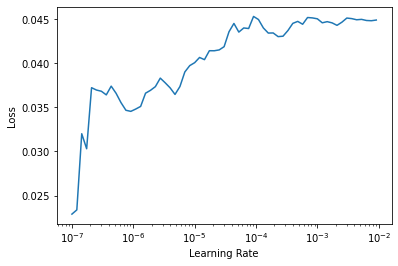

In [37]:
#collapse-show
learn.lr_find() # find learning rate

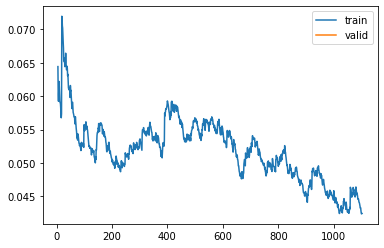

In [28]:
#collapse-show
learn.recorder.plot_loss() # plot learning rate graph

In [ ]:
#collapse-show
lrs = slice(10e-6, 10e-5)
learn.fit_one_cycle(12, lrs)

epoch,train_loss,valid_loss,time
0,0.034851,0.085248,25:39
1,0.032958,0.089029,25:40


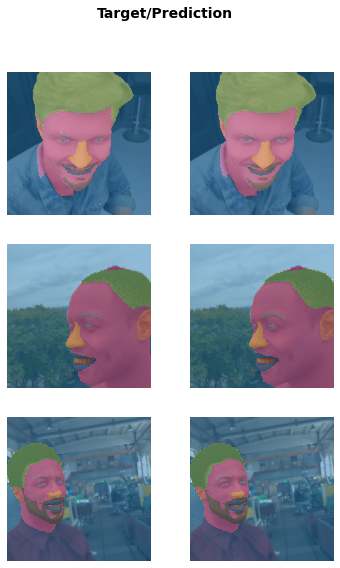

In [36]:
#collapse-show
learn.show_results()

# Model Validation
## Validation Data Set
After iterating the process of sampling the model to determine the best variable learning rate bounds through about 24 hrs worth of compute cycles, I started looking at the target data set provided from Schniter and Shields{% fn 2 %}. The data set contains 2 frontal photos per subject showing faces of participants with microphone and speaker headsets, while seated at computer terminal cubicles in a laboratory setting, which were captured from video recordings of the participants.

The full-face photographs of 96 young adults aged 18 to 25 years old (51 men, 45 women) were captured from video recorded under standardized videographic conditions. All individuals video recorded were between # and # years old and were students at Chapman University in Orange, CA. Videos were taken in a computer terminal cubicle against a background of either a gray carpeted cubicle or a brown wall under standardized diffuse lighting conditions, and participants were instructed to sit upright and look at the camera mounted above the computer screen they were facing. Camera-to-head distance was controlled by the cubicle space and chair position, and camera settings were held constant. Video was taken using Logitech C920 1080P HD digital cameras. Photographs (640 x 480 pixel .jpg files, 24 Bit depth (R,G,B)) were captured as  from video frames using the VLC media player (3.0.11) “snapshot” tool.

The subjects were participants in an economic experiment, interacting anonymously with matched partners two rounds of a repeated Prisoner’s Dilemma game.  Participants knew that at no time would there image be transmitted to other participants during the original economic experiment. The researchers captured video of the participants with their permission for later reuse. The researchers were interested in whether information in the faces of participants (e.g. face proportions, coloration, expressions) was predictive of their game play (i.e., cooperate or cheat) and whether third parties could accurately guess their game play based on viewing their faces (from photos or thin-slice videos).

In [35]:
mod_dir = path/'Models'
mod_fp_chk = mod_dir/'checkpoint_20201007'
mod_fp.parent.mkdir(parents=True, exist_ok=True)
# learn.save(mod_fp)
learn.export(mod_fp_chk)

In [284]:
erics_img = Path('/ws/data/skin-tone/ScreenshotFaceAfterStatement/erics_imgs')
ls = erics_img.ls()

## Example Image
We can see in the example image, and its predicted mask that the model generalized decently well, but there were some issues.  Below, it struggled with the headphones, and misclassifies the General Face down the subject's neck.  For many tasks, this will be a sufficient regional localization because the Nose, Eyes and Mouth are accurately labeled allowing for post-processing to eliminate the inaccuracies.  For example measuring skin-tone, we care about the region that is labeled pink in the mask that is "General face", and the portion that is labeled orange that is "Nose".  Those are the labels that are of "skin tone".  The main objective before shipping this model is to determine from a metric standpoint (accuracy) and from an intuitive standpoint (looking at the images) whether or not the nose and face labels are accurate enough.

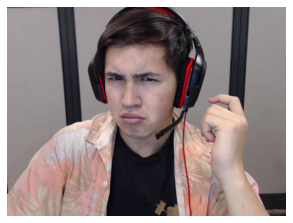

In [285]:
img = PILImage.create(ls[11])
pmask = learn.predict(item=img)
img.show(figsize=(5, 5), alpha=1)

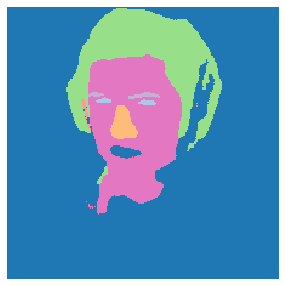

In [286]:
pmask[0].show(figsize=(5, 5), alpha=1)

## Filtering on a Confidence Threshold
I was curious whether we could apply a simple rule to the output from the UNet prediction that would improve effective accuracy without any more training epochs, since training epochs are expensive (25 minutes).  If I were to get this model training faster with more GPUs or more GPU Memory or code enhancements, I would try a lot of different things in earlier stages to make the network more accurate.  Here is the code that implements the confidence threshold.

In [288]:
# check pred
thresh = 0.99
low_conf = []
errors = []
new_decision = pmask[1].clone()
for i in range(pmask[1].shape[0]):
    for j in range(pmask[1].shape[1]):
        decision = pmask[1][i, j]
        decision_me, conf = pred_with_prob(
            pix_vals=pmask[2][:, i, j]
        )
        
        if not decision == decision_me[0,0]:
            errors.append([i,j])
        if conf < thresh:
            low_conf.append([i,j])
            new_decision[i,j] = 0

### Base Image

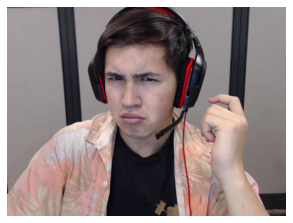

In [290]:
img.show(figsize=(5, 5), alpha=1)

### Unfiltered Prediction

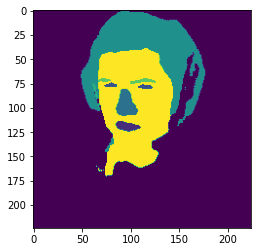

In [291]:
plt.imshow(pmask[0])

### Filtered Prediction

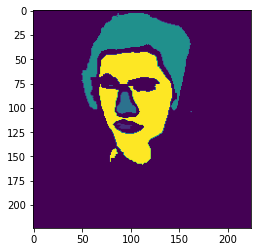

In [292]:
plt.imshow(new_decision)

# Conclusions
## In Summation
1. The UNet worked well out-of-the-box using the default process.  Yay!
2. The UNet trains slow on my experimental deep learning box
3. The regions of the face that are topologically interesting like the nose, mouth, eyes and hair are predicted well.  These regions can be leveraged to improve the accuracy of a skin-tone predictor by further isolating regions such as cheeks and forehead. 

## Next Steps
1. Improve Unet model accuracy  
 a. Parameter Sweeps  
 b. Learning Rate Selections  
 c. Code Efficiency + More Hardware (Google Colab?) = More Epochs  
 d. Try different backbones: resnet18, resnet50, other...  
 e. Try different pre-trained weights: Try fine-tuning the pre-trained weights using faces  

# Citations
{{ 'Mut1ny.com.  (2020).  "Mut1ny Facial/Headsegmentation dataset. https://www.mut1ny.com/face-headsegmentation-dataset' | fndetail: 1 }}
{{ 'Schniter, E., Shields, T. (2020). "Participant Faces From a Repeated Prisoner’s Dilemma". Unpublished raw data.' | fndetail: 2 }}
{{ '(2020). "What Segmentation model to use?". https://www.mut1ny.com/face-headsegmentation-dataset/10-segmentation-data/17-what-segmentation-model-to-use, 2020' | fndetail: 3 }}
{{ '(2020). "What Segmentation model to use? Part 2". https://www.mut1ny.com/face-headsegmentation-dataset/10-segmentation-data/19-what-segmentation-model-to-use-2
' | fndetail: 4 }}
{{'Biewald, L. "The story of Fast.ai & why Python is not the future of ML with Jeremy Howard". (2020). https://www.wandb.com/podcast/jeremy-howard' | fndetail: 5}}
{{'Howard, J. "Lesson 3: Deep Learning 2019 - Data blocks; Multi-label classification; Segmentation". (2019). https://youtu.be/MpZxV6DVsmM?t=4176. 1:09:00' | fndetail: 6}}
{{'WaterKnight1998.  (2020 Sept 8). Githash:80f6c04. https://github.com/WaterKnight1998/Deep-Tumour-Spheroid/blob/develop/notebooks/DeepLabV3+.ipynb' | fndetail: 7}}
{{'Ray. https://ray.io/' | fndetail: 8}}
{{'Ronneberger, O. "U-Net: Convolutional Networks for Biomedical Image Segmentation".  (2015). https://arxiv.org/abs/1505.04597' | fndetail: 9}}
{{'He, K., Zhang, X., Ren, S. and Sun, J. "Deep Residual Learning for Image Recognition".  (2015). https://arxiv.org/abs/1512.03385' | fndetail: 10}}
{{'Pytorch, Torchvision. "TORCHVISION.MODELS".  (2020). https://pytorch.org/docs/stable/torchvision/models.html' | fndetail: 11}}
{{'Google Machine Learning Glossary. "Epoch".  https://developers.google.com/machine-learning/glossary#epoch' | fndetail: 12}}
{{'Howard, J. "Lesson 3 - Deep Learning for Coders (2020)".  (2020). https://youtu.be/5L3Ao5KuCC4?t=5988.  1:40:00' | fndetail: 12}}
{{'PyTorch.  "TORCH.TENSOR".  (2020). https://pytorch.org/docs/stable/tensors.html.' | fndetail: 13}}
{{'Yang, S., Luo, P., Loy C.C. "Faceness-Net: Face Detection through
Deep Facial Part Responses".  (2017). https://arxiv.org/pdf/1701.08393.pdf.' | fndetail: 14}}
